# KNN, SVM, Data Preprocessing, and Scikit-learn Pipeline

In [6]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.6.8
import os, itertools, csv

from IPython.display import Image
from IPython.display import display

# numpy  1.19.5
import numpy as np

# pandas  0.25.3
import pandas as pd

# scikit-learn  0.22
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_moons
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import SVC

# matplotlib  3.1.2
import matplotlib
from matplotlib.colors import ListedColormap
matplotlib.rcParams.update({'font.size': 22})
plt = matplotlib.pyplot

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
from lib import *

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")

## Nonlinearly Separable Data

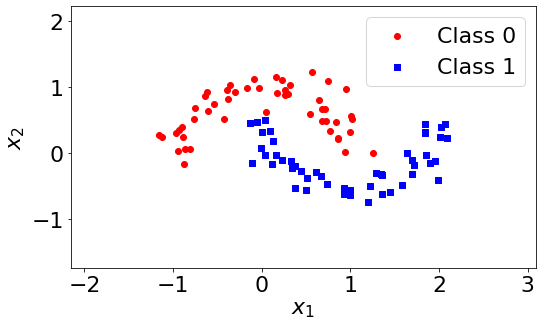

In [5]:
X, y = make_moons(n_samples=100, noise=0.15, random_state=0)

plt.figure(figsize=(8, 5))
plt.scatter(X[y == 0, 0], X[y == 0, 1],
            c='r', marker='o', label='Class 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1],
            c='b', marker='s', label='Class 1')

plt.xlim(X[:, 0].min()-1, X[:, 0].max()+1)
plt.ylim(X[:, 1].min()-1, X[:, 1].max()+1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('./output/fig-two-moon.png', dpi=300)
plt.show()

In [7]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[: len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x = X[y == cl, 0],
            y = X[y == cl, 1],
            alpha = 0.8,
            c = [cmap(idx)], # Prevents warning
            marker = markers[idx],
            label = cl
        )

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='lightgray',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set', edgecolors='k')

[Perceptron]
Misclassified samples: 3
Accuracy: 0.85


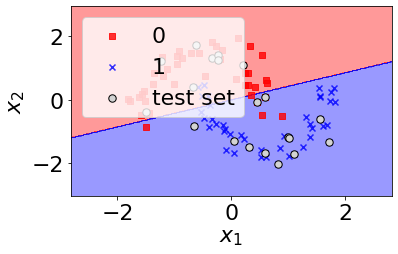

[Logistic regression]
Misclassified samples: 3
Accuracy: 0.85


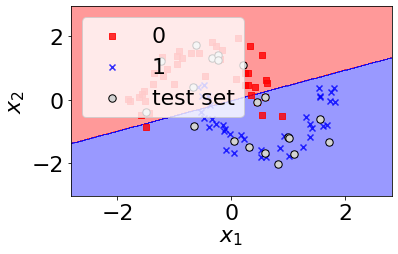

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

ppn = Perceptron(max_iter=1000, eta0=0.1, random_state=0)
ppn.fit(X_train_std, y_train)
y_pred = ppn.predict(X_test_std)
print('[Perceptron]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot decision regions for Perceptron
plot_decision_regions(X_combined_std, y_combined,
                      classifier=ppn, 
                      test_idx=range(y_train.size, 
                                     y_train.size + y_test.size))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-two-moon-perceptron-boundray.png', dpi=300)
plt.show()

lr = LogisticRegression(C = 1000.0, random_state = 0, solver = "liblinear")
lr.fit(X_train_std, y_train)

y_pred = lr.predict(X_test_std)
print('[Logistic regression]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot decision regions for LogisticRegression
plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, 
                      test_idx=range(y_train.size, 
                                     y_train.size + y_test.size))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-two-moon-logistic-regression-boundray.png', dpi=300)
plt.show()

## K-Nearest Neighbors Classifier

[KNN]
Misclassified samples: 1
Accuracy: 0.95


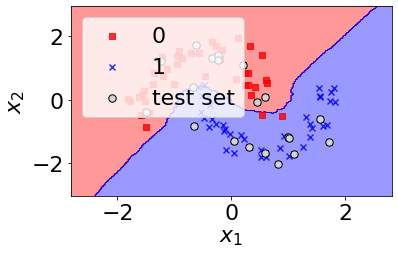

In [9]:
# p=2 and metric='minkowski' means the Euclidean Distance
knn = KNeighborsClassifier(n_neighbors=11, p=2, metric='minkowski')

knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)
print('[KNN]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot decision regions for knn classifier
plot_decision_regions(X_combined_std, y_combined,
                      classifier=knn, 
                      test_idx=range(y_train.size,
                                     y_train.size + y_test.size))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-two-moon-knn-boundray.png', dpi=300)
plt.show()

## Support Vector Classifier

[Linear SVC]
Misclassified samples: 3
Accuracy: 0.85


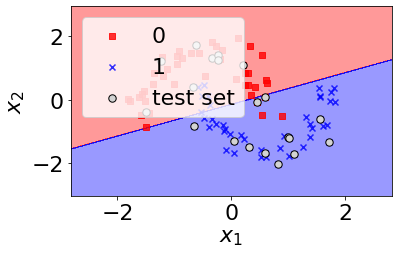

[Nonlinear SVC]
Misclassified samples: 1
Accuracy: 0.95


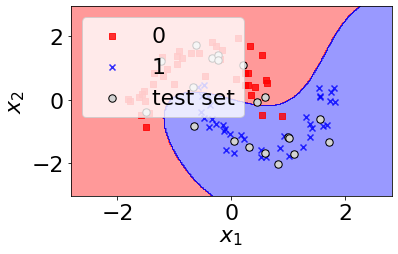

In [10]:
# kernel: the kernel function, can be 'linear', 'poly', 'rbf', ...etc
# C is the hyperparameter for the error penalty term
svm_linear = SVC(kernel='linear', C=1000.0, random_state=0)

svm_linear.fit(X_train_std, y_train)
y_pred = svm_linear.predict(X_test_std)
print('[Linear SVC]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot decision regions for linear svm
plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm_linear, 
                      test_idx=range(y_train.size,
                                     y_train.size + y_test.size))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/figtwo-moon-svm-linear-boundray.png', dpi=300)
plt.show()

# C is the hyperparameter for the error penalty term
# gamma is the hyperparameter for the rbf kernel
svm_rbf = SVC(kernel='rbf', random_state=0, gamma=0.2, C=10.0)

svm_rbf.fit(X_train_std, y_train)
y_pred = svm_rbf.predict(X_test_std)
print('[Nonlinear SVC]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

# plot decision regions for rbf svm
plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm_rbf, 
                      test_idx=range(y_train.size, 
                                     y_train.size + y_test.size))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-two-moon-svm-rbf-boundray.png', dpi=300)
plt.show()

### Tune the hyperparameters

In [11]:
print('[Nonlinear SVC: C=1000, gamma=0.01]')
svm = SVC(kernel='rbf', random_state=0, gamma=0.01, C=1000.0)
svm.fit(X_train_std, y_train)
y_pred = svm.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

print('\n[Nonlinear SVC: C=1, gamma=1]')
svm = SVC(kernel='rbf', random_state=0, gamma=0.0001, C=10.0)
svm.fit(X_train_std, y_train)
y_pred = svm.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

[Nonlinear SVC: C=1000, gamma=0.01]
Misclassified samples: 3
Accuracy: 0.85

[Nonlinear SVC: C=1, gamma=1]
Misclassified samples: 11
Accuracy: 0.45


## Grid Search

In [12]:
param_C = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
param_gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]

svm = SVC(random_state=0)

# set the param_grid parameter of GridSearchCV to a list of dictionaries
param_grid = [{'C': param_C, 
               'gamma': param_gamma, 
               'kernel': ['rbf']}]
gs = GridSearchCV(estimator=svm, 
                  param_grid=param_grid, 
                  scoring='accuracy')

gs = gs.fit(X_train_std, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9625
{'C': 10.0, 'gamma': 1.0, 'kernel': 'rbf'}



[Nonlinear SVC: grid search]
Test accuracy: 1.00


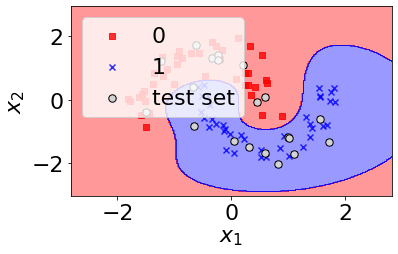

In [13]:
clf = gs.best_estimator_
clf.fit(X_train_std, y_train)
print('\n[Nonlinear SVC: grid search]')
print('Test accuracy: %.2f' % clf.score(X_test_std, y_test))

# plot decision regions for rbf svm
plot_decision_regions(X_combined_std, y_combined,
                      classifier=gs.best_estimator_, 
                      test_idx=range(y_train.size, 
                                     y_train.size + y_test.size))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('./output/fig-two-moon-svm-rbf-gs-boundray.png', dpi=300)
plt.show()

## Data Preprocessing

In [14]:
# we set sep=', ' since this dataset is not a regular csv file
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'adult/adult.data', header=None, sep=', ', engine='python')

df.columns = ['age', 'workclass', 'fnlwgt', 'education', 
              'education-num', 'marital-status', 'occupation', 
              'relationship', 'race', 'sex', 'capital-gain', 
              'capital-loss', 'hours-per-week', 'native-country', 
              'label']

display(df.head(15))

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


### Encode Label

In [15]:
# encode label first
label_le = LabelEncoder()
df['label'] = label_le.fit_transform(df['label'].values)

# encode categorical features
catego_features = ['workclass', 'education', 'marital-status', 'occupation', 
                   'relationship', 'race', 'sex', 'native-country']

catego_le = LabelEncoder()

# transform categorical values into numerical values
# be careful that '?' will also be encoded
# we have to replace it to NaN in numerical
categories = []
for i in catego_features:
    df[i] = catego_le.fit_transform(df[i].values)
    classes_list = catego_le.classes_.tolist()
    
    # replace '?' with 'NaN'
    if '?' in classes_list:
        idx = classes_list.index('?')
        df[i] = df[i].replace(idx, np.nan)
    
    # store the total number of values
    categories.append(np.arange(len(classes_list)))

display(df.head(15))

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,7.0,77516,9,13,4,1.0,1,4,1,2174,0,40,39.0,0
1,50,6.0,83311,9,13,2,4.0,0,4,1,0,0,13,39.0,0
2,38,4.0,215646,11,9,0,6.0,1,4,1,0,0,40,39.0,0
3,53,4.0,234721,1,7,2,6.0,0,2,1,0,0,40,39.0,0
4,28,4.0,338409,9,13,2,10.0,5,2,0,0,0,40,5.0,0
5,37,4.0,284582,12,14,2,4.0,5,4,0,0,0,40,39.0,0
6,49,4.0,160187,6,5,3,8.0,1,2,0,0,0,16,23.0,0
7,52,6.0,209642,11,9,2,4.0,0,4,1,0,0,45,39.0,1
8,31,4.0,45781,12,14,4,10.0,1,4,0,14084,0,50,39.0,1
9,42,4.0,159449,9,13,2,4.0,0,4,1,5178,0,40,39.0,1


### Deal with Missing Data

In [16]:
# count the number of missing values per column
display(df.isnull().sum())

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
label                0
dtype: int64

In [17]:
print(df.shape)

# drop rows with missing values
df_drop_row = df.dropna()
print(df_drop_row.shape)

(32561, 15)
(30162, 15)


In [18]:
print('Original: {}'.format(df.shape))

# drop columns with missing values
df_drop_col = df.dropna(axis=1)
print('Drop column: {}'.format(df_drop_col.shape))

# drop rows or columns where all values are NaN
df_drop_row_all = df.dropna(how='all')
print('Drop row all: {}'.format(df_drop_row_all.shape))

# keep rows that have at least 14 non-NaN values
df_drop_row_thresh = df.dropna(thresh=14)
print('Drop row 14: {}'.format(df_drop_row_thresh.shape))

# only drop rows where NaN appear in specific columns (here: 'occupation')
df_drop_row_occupation = df.dropna(subset=['occupation'])
print('Drop row occupation: {}'.format(df_drop_row_occupation.shape))

Original: (32561, 15)
Drop column: (32561, 12)
Drop row all: (32561, 15)
Drop row 14: (30725, 15)
Drop row occupation: (30718, 15)


#### Imputing Missing Data

In [19]:
imr = SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)

df_impute = pd.DataFrame(imputed_data)
df_impute.columns = df.columns

display(df.head(15))
display(df_impute.head(15))

# check if there are still missing values
display(df_impute.isnull().sum())

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,7.0,77516,9,13,4,1.0,1,4,1,2174,0,40,39.0,0
1,50,6.0,83311,9,13,2,4.0,0,4,1,0,0,13,39.0,0
2,38,4.0,215646,11,9,0,6.0,1,4,1,0,0,40,39.0,0
3,53,4.0,234721,1,7,2,6.0,0,2,1,0,0,40,39.0,0
4,28,4.0,338409,9,13,2,10.0,5,2,0,0,0,40,5.0,0
5,37,4.0,284582,12,14,2,4.0,5,4,0,0,0,40,39.0,0
6,49,4.0,160187,6,5,3,8.0,1,2,0,0,0,16,23.0,0
7,52,6.0,209642,11,9,2,4.0,0,4,1,0,0,45,39.0,1
8,31,4.0,45781,12,14,4,10.0,1,4,0,14084,0,50,39.0,1
9,42,4.0,159449,9,13,2,4.0,0,4,1,5178,0,40,39.0,1


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39.0,7.0,77516.0,9.0,13.0,4.0,1.0,1.0,4.0,1.0,2174.0,0.0,40.0,39.0,0.0
1,50.0,6.0,83311.0,9.0,13.0,2.0,4.0,0.0,4.0,1.0,0.0,0.0,13.0,39.0,0.0
2,38.0,4.0,215646.0,11.0,9.0,0.0,6.0,1.0,4.0,1.0,0.0,0.0,40.0,39.0,0.0
3,53.0,4.0,234721.0,1.0,7.0,2.0,6.0,0.0,2.0,1.0,0.0,0.0,40.0,39.0,0.0
4,28.0,4.0,338409.0,9.0,13.0,2.0,10.0,5.0,2.0,0.0,0.0,0.0,40.0,5.0,0.0
5,37.0,4.0,284582.0,12.0,14.0,2.0,4.0,5.0,4.0,0.0,0.0,0.0,40.0,39.0,0.0
6,49.0,4.0,160187.0,6.0,5.0,3.0,8.0,1.0,2.0,0.0,0.0,0.0,16.0,23.0,0.0
7,52.0,6.0,209642.0,11.0,9.0,2.0,4.0,0.0,4.0,1.0,0.0,0.0,45.0,39.0,1.0
8,31.0,4.0,45781.0,12.0,14.0,4.0,10.0,1.0,4.0,0.0,14084.0,0.0,50.0,39.0,1.0
9,42.0,4.0,159449.0,9.0,13.0,2.0,4.0,0.0,4.0,1.0,5178.0,0.0,40.0,39.0,1.0


age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
label             0
dtype: int64

### One-hot Encoding

In [25]:
# we perform one-hot encoding on both impute data and drop-row data
impute_data = df_impute.values
drop_row_data = df_drop_row.values

# find the index of the categorical feature
catego_features_idx = []
for fea in catego_features:
    
    catego_features_idx.append(df.columns.tolist().index(fea))

# give the column index you want to do one-hot encoding
ohe = ColumnTransformer(
    [
        ("one_hot_encoder", OneHotEncoder(sparse = False, categories = "auto"), catego_features_idx)
    ],
    remainder = "passthrough"
)

impute_onehot_data = ohe.fit_transform(impute_data)
print('Impute: {}'.format(impute_data.shape))
print('Impute one-hot: {}'.format(impute_onehot_data.shape))

drop_row_onehot_data = ohe.fit_transform(drop_row_data)
print('Drop row: {}'.format(drop_row_data.shape))
print('Drop row one-hot: {}'.format(drop_row_onehot_data.shape))

Impute: (32561, 15)
Impute one-hot: (32561, 106)
Drop row: (30162, 15)
Drop row one-hot: (30162, 105)


### The get_dummy( ) Method in Pandas

In [26]:
df_dummy = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'adult/adult.data',
                 header=None, sep=', ', engine='python')

df_dummy.columns = ['age', 'workclass', 'fnlwgt', 'education', 
                    'education-num', 'marital-status', 'occupation', 
                    'relationship', 'race', 'sex', 'capital-gain', 
                    'capital-loss', 'hours-per-week', 'native-country', 
                    'label']

# encode label first
label_le = LabelEncoder()
df_dummy['label'] = label_le.fit_transform(df_dummy['label'].values)

# remove rows with missing data
df_dummy = df_dummy.replace('?', np.nan)
df_dummy_drop_row = df_dummy.dropna()
# here we cannot use sklearn.Imputer, since it only accepts numerical values

# one-hot encoding
df_dummy_drop_row = pd.get_dummies(df_dummy_drop_row)
display(df_dummy_drop_row.head())

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Scikit-learn Pipeline

In [28]:
df_small = df.sample(n = 4000, random_state = 0)

X = df_small.drop('label', axis=1).values
y = df_small['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

ohe = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(categories = categories, sparse = False), catego_features_idx),
    ],
    remainder = "passthrough"
)

# define pipeline with an arbitrary number of transformer in a tuple array
pipe_knn = Pipeline([
    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
    ("ohe", ohe),
    ("scl", StandardScaler()),
    ("clf", KNeighborsClassifier(n_neighbors = 10, p = 2, metric = "minkowski"))
])

pipe_svm = Pipeline([
    ("imr", SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
    ("ohe", ohe),
    ("scl", StandardScaler()),
    ('clf', SVC(kernel = "rbf", random_state = 0, gamma = 0.001, C = 100.0))
])

# use the pipeline model to train
pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)
print('[KNN]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

pipe_svm.fit(X_train, y_train)
y_pred = pipe_svm.predict(X_test)
print('\n[SVC]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

[KNN]
Misclassified samples: 158
Accuracy: 0.8025

[SVC]
Misclassified samples: 134
Accuracy: 0.8325


We can check whether one-hot encoding is useful or not:



In [29]:
pipe_knn = Pipeline([
    ('imr', SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
    ('scl', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=10, p=2, metric='minkowski'))
])

pipe_svm = Pipeline([
    ('imr', SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')),
    ('scl', StandardScaler()),
    ('clf', SVC(kernel='rbf', random_state=0, gamma=0.001, C=100.0))
])

pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)
print('[KNN: no one-hot]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

pipe_svm.fit(X_train, y_train)
y_pred = pipe_svm.predict(X_test)
print('\n[SVC: no one-hot]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

[KNN: no one-hot]
Misclassified samples: 156
Accuracy: 0.8050

[SVC: no one-hot]
Misclassified samples: 151
Accuracy: 0.8113


As we can see, the performance of KNN does not change much because the model has no preference on specific numerical values. On the other hand, the accuracy drops in SVC because it has a weight decay term in the cost function that can be misled when the categorical features are not encoded as one-hot vectors.

In [30]:
# keep only data points without NaN features
idx = np.isnan(X_train).sum(1) == 0
X_train = X_train[idx]
y_train = y_train[idx]
idx = np.isnan(X_test).sum(1) == 0
X_test = X_test[idx]
y_test = y_test[idx]

ohe = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(categories = categories, sparse = False), catego_features_idx),
    ],
    remainder = "passthrough"
)

pipe_knn = Pipeline([
                    ('ohe', ohe),
                    ('scl', StandardScaler()),
                    ('clf', KNeighborsClassifier(n_neighbors=10, p=2, metric='minkowski'))
])

pipe_svm = Pipeline([
                    ('ohe', ohe),
                    ('scl', StandardScaler()),
                    ('clf', SVC(kernel='rbf', random_state=0, gamma=0.001, C=100.0))
])

# use the pipeline model to train
pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)
print('[KNN: drop row]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

pipe_svm.fit(X_train, y_train)
y_pred = pipe_svm.predict(X_test)
print('\n[SVC: drop row]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

[KNN: drop row]
Misclassified samples: 148
Accuracy: 0.8008

[SVC: drop row]
Misclassified samples: 126
Accuracy: 0.8304


In [31]:
pipe_svm = Pipeline([
                    ('ohe',
                        ColumnTransformer(
                            [
                                ('ohe', OneHotEncoder(categories = categories, sparse = False), catego_features_idx),
                            ],
                            remainder = "passthrough"
                        )
                    ),
                    ('scl', StandardScaler()),
                    ('clf', SVC(random_state=0))
])

param_gamma = [0.0001, 0.001, 0.01, 0.1, 1.0]
param_C = [0.1, 1.0, 10.0, 100.0]

# here you can set parameter for different steps 
# by adding two underlines (__) between step name and parameter name
param_grid = [{'clf__C': param_C, 
               'clf__kernel': ['linear']},
              {'clf__C': param_C, 
               'clf__gamma': param_gamma, 
               'clf__kernel': ['rbf']}]

# set pipe_svm as the estimator
gs = GridSearchCV(
    estimator = pipe_svm, 
    param_grid = param_grid, 
    scoring = "accuracy",
    cv = 3
)

gs = gs.fit(X_train, y_train)
print('[SVC: grid search]')
print('Validation accuracy: %.3f' % gs.best_score_)
print(gs.best_params_)

clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

[SVC: grid search]
Validation accuracy: 0.835
{'clf__C': 100.0, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
Test accuracy: 0.830
